# Applications Final Data Prep

In [ ]:
%matplotlib inline

import datetime as dt
import itertools as it
import pandas as pd

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import synapseclient
from synapseclient import Activity, File, Schema, Table, as_table_columns

InteractiveShell.ast_node_interactivity = 'all'
syn = synapseclient.Synapse()
syn.login()

def isnum(x):
    if x is None:
        return False
    try:
        float(x)
        return True
    except ValueError:
        return False

In [ ]:
v1sid, v2sid = 'syn10250489', 'syn17023091'

v1r = pd.read_excel(syn.get(v1sid).path)
v2r = pd.read_csv(syn.get(v2sid).path, parse_dates=['createdAt'])

v1r.head()
v2r.head()

### V1 Data Prep

In [ ]:
# drop the uneeded columns
v1 = v1r.drop(columns=[
    'week',	'user_id',	'sent_time_local',	'sent_time_utc', 'response_utc', 'response_id'
]).rename(columns={
    'brightenid': 'participant_id',
    'response_local':'dt_response',
    'Why did you download this app?':'apps',
    'For "other", please type in box':'other_description'
})

# conver to lowercase for lookups
v1.apps = v1.apps.apply(lambda x: x.lower() if not isnum(x) else 'none')

# add indicators for different app usage
v1['fun'] = v1.apps.apply(lambda x: int(x.find('fun') > -1))
v1['mental_health'] =  v1.apps.apply(lambda x: int(x.find('mental health') > -1))
v1['mood'] =  v1.apps.apply(lambda x: int(x.find('mood') > -1))
v1['managing_daily_issues'] =  v1.apps.apply(lambda x: int(x.find('management of daily ') > -1))
v1['improve_work'] =  v1.apps.apply(lambda x: int(x.find('improve work') > -1))
v1['brain_health'] =  v1.apps.apply(lambda x: int(x.find('brain health') > -1))
v1['improve_relationships'] =  v1.apps.apply(lambda x: int(x.find('improve relationships') > -1))
v1['other'] =  v1.apps.apply(lambda x: int(x.find('other') > -1))

v1.head()

In [4]:
# print the unique application reasons
t = [print(a) for a in pd.unique(list(it.chain(*[t.split('|') for t in v1.apps])))]; del t

for fun
for mental health reasons [e.g. depression; anxiety; adhd]
for brain health [e.g. better memory]
to improve work
for management of daily problems
for mood [e.g. sadness]
to improve relationships
other
none


(array([234.,  45.,  11.,   2.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([  1. ,  24.7,  48.4,  72.1,  95.8, 119.5, 143.2, 166.9, 190.6,
        214.3, 238. ]),
 <a list of 10 Patch objects>)

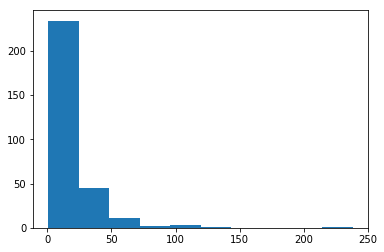

In [5]:
plt.hist([len(a) for a in v1.other_description if not isnum(a)])

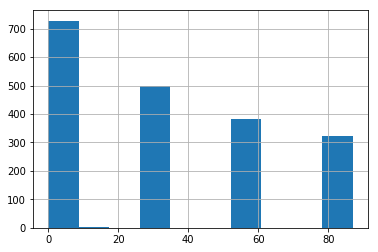

In [6]:
v1['day'] = [(t.dt_response - t.start).days + 1 for t in v1.itertuples()]
v1.day.hist()

#### Extract two common topics I saw a quick read through the other descriptions

In [7]:
incentive_words = [
    'paid', 'pay', 'mone', 'compens', 'gift', 'incentive', '$', 'finan', 'incom', 'reimb', 'craigs', 'pd'
]

def is_incentive(s):
    if not isinstance(s, str):
        return 0
    else:
        return int(any(s.find(a) > -1 for a in incentive_words))
    
v1['happ_inc'] = pd.to_numeric(v1.other_description.apply(is_incentive), downcast='integer')

In [8]:
for_the_study_words = [
    'part', 'require', 'for study', 'told to', 'asked to', 'request', 'to be', 'to do', 'brighten', 'assignment', 'ucsf', 'for a', 'study'
]

def is_for_the_study(s):
    if not isinstance(s, str):
        return int(0)
    else:
        return int(any(s.find(a) > -1 for a in for_the_study_words))
    
v1['happ_fts'] = v1.other_description.apply(is_for_the_study)

In [9]:
v1 = v1.drop(columns=['start', 'day'])

### V2 Data Prep

In [ ]:
# drop the uneeded columns
v2 = v2r.rename(columns={
    'username': 'participant_id',
    'createdAt':'dt_response',
    'Why did you download this app?':'apps'
})

# conver to lowercase for lookups
v2.apps = v2.apps.apply(lambda x: x.lower() if not isnum(x) else 'none')

# add indicators for different app usage
v2['fun'] = v2.apps.apply(lambda x: int(x.find('fun') > -1))
v2['mental_health'] =  v2.apps.apply(lambda x: int(x.find('my mental health') > -1))
v2['mood'] =  v2.apps.apply(lambda x: int(x.find('my mood') > -1))
v2['managing_daily_issues'] =  v2.apps.apply(lambda x: int(x.find('managing daily issues') > -1))
v2['improve_work'] =  v2.apps.apply(lambda x: int(x.find('improve work') > -1))
v2['brain_health'] =  v2.apps.apply(lambda x: int(x.find('brain health') > -1))
v2['improve_relationships'] =  v2.apps.apply(lambda x: int(x.find('improve relationships') > -1))
v2['other'] =  v2.apps.apply(lambda x: int(x.find('other') > -1))

# add the study flag
v2.head()

In [12]:
t = [print(a) for a in pd.unique(list(it.chain(*[t.split(',') for t in v2.apps])))]; del t

fun
my mental health
my mood
managing daily issues
improve work
brain health
improve relationships
other


### Combine the DataFrames

In [ ]:
combined = pd.concat([v1, v2], sort=False)

combined = combined.drop(columns=['apps']).rename(columns={
    'brain_health': 'happ_bh',
    'fun': 'happ_f',
    'improve_relationships': 'happ_ir',
    'improve_work': 'happ_iw',
    'managing_daily_issues': 'happ_mdi',
    'mental_health': 'happ_mh',
    'mood':'happ_m',
    'other': 'happ_o',
    'other_description':'happ_o_description'
}).loc[:, [
    'participant_id', 'dt_response', 
    'happ_bh', 'happ_f', 'happ_fts', 'happ_inc', 'happ_ir', 'happ_iw', 'happ_m', 'happ_mdi', 'happ_mh', 'happ_o',
    'happ_o_description'
]]

combined = combined.fillna(0)

# make sure they're all the correct type. for some reason pandas was converting fts and inc to floats
# but we don't need that many bits. plus i like consistency
for c in combined.columns:
    if c.find('description') > -1:
        continue 
        
    if c.find('app') > -1:
        combined[c] = combined[c].astype(int)

combined.head()

### Set provenance and upload to Synapse

In [14]:
final = syn.store(Table(
    Schema(
            name='Health Applications Use',
            columns=as_table_columns(combined), 
            parent='syn10848316'),
        combined
    )
)

In [15]:
final = syn.setProvenance(
    'syn17022426',
    activity=Activity(
        name='Combine V1 and V2 data',
        description='Process and combine the data collected during study 1 and study 2',
        used=['syn17023091', v1sid, v2sid, 'syn12181332'],
        executed=[
            dict(
                name='IPython Notebook',
                url='https://github.com/apratap/BRIGHTEN-Data-Release/blob/master/Create_HealthApplications_datafiles.ipynb'
            )
        ]
    )
)